In [27]:
# checking strategy sell put spread SPY 


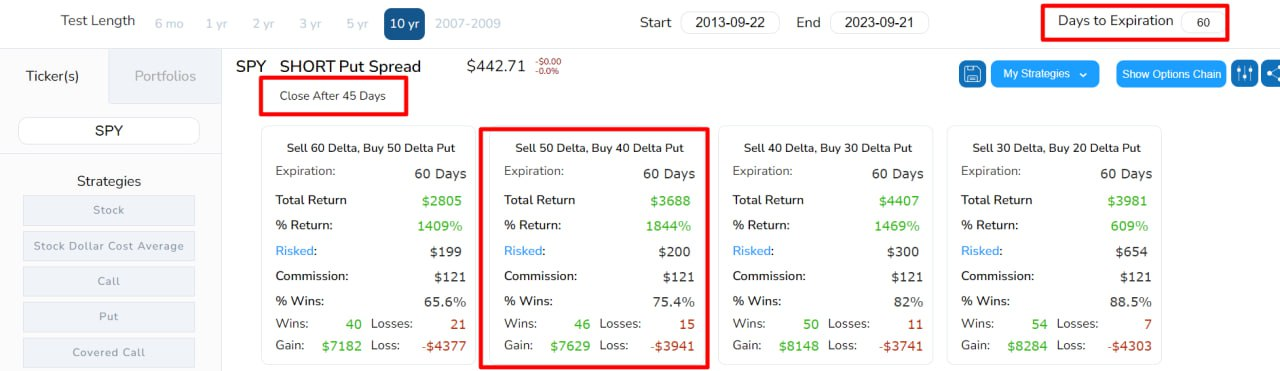

In [28]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go

#Global var
init_cap = 2000
price_limit = 10000 # don't open position if price exceeded price_limit
risk_free_rate = 5.0

#directory path
dir_path =r'D:\OneDrive\stock\Leleka\BuyBeforeEarnings\inputForPython'
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

if not csv_files:
    print('No CSV file in directory')



### Working with CML download files

In [29]:
# Add all files in folder in one file
dataframes={}
all_data = []  # List to store all individual dataframes

for file in csv_files:
    file_path = os.path.join(dir_path, file)
    df = pd.read_csv(file_path)
    key_name = os.path.splitext(file)[0]
    dataframes[key_name] = df
    all_data.append(df)

# Concatenate all individual dataframes to form a single dataframe
combined_df = pd.concat(all_data, ignore_index=True)

In [30]:
#
# combined_df

In [31]:
# remove dollar symbol
combined_df['Profit/Loss'] = combined_df['Profit/Loss'].str.replace('$','', regex = False)
combined_df['Trade Price'] = combined_df['Trade Price'].str.replace('$','', regex = False)
combined_df['Stock Price'] = combined_df['Stock Price'].str.replace('$','', regex = False)
combined_df['Adjusted Stock Price'] = combined_df['Adjusted Stock Price'].str.replace('$','', regex = False)

# convert in numbers
combined_df['Profit/Loss']= pd.to_numeric(combined_df['Profit/Loss'],errors='coerce')
combined_df['Trade Price']= pd.to_numeric(combined_df['Trade Price'],errors='coerce')

# convert date 
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df.reset_index(drop=True)


In [32]:
#combined_df.to_excel('combined_df.xlsx')


In [33]:
#combined_df

### Add Year and sort data

In [34]:
# Add year column and Y_Symbol column
combined_df['Year'] = combined_df['Date'].dt.year
#combined_df['Y_Symbol'] = combined_df['Year'].astype(str).str.cat(combined_df['Symbol'], sep='')


# sort by date to build chart
combined_df = combined_df.sort_values(by='Date')

In [35]:
combined_df

,Date,Description,Size,Symbol,Expiration,Strike,Type,Trade Price,Profit/Loss,Stock Price,Adjusted Stock Price,Year
0,2007-01-03,Open DaysToDate:Short Puts,-1,SPY,17-Mar-07,142,Put,2.85,NaN,141.37,122.72,2007
1,2007-01-03,Open DaysToDate:Long Puts,1,SPY,17-Mar-07,140,Put,2.17,NaN,141.37,122.72,2007
2,2007-03-09,Close CloseAfterDays:Short Puts,1,SPY,17-Mar-07,142,Put,1.98,86.0,140.78,122.21,2007
3,2007-03-09,Close CloseAfterDays:Long Puts,-1,SPY,17-Mar-07,140,Put,0.90,-128.0,140.78,122.21,2007
4,2007-03-19,Open DaysToDate:Short Puts,-1,SPY,19-May-07,141,Put,2.95,NaN,140.20,122.19,2007
...,...,...,...,...,...,...,...,...,...,...,...,...
404,2023-09-15,Roll-Open 60DaysToExpiration:Short Puts,-1,SPY,17-Nov-23,446,Put,8.75,NaN,443.37,443.37,2023
402,2023-09-15,Roll-Close DaysToExpiration:Short Puts,1,SPY,15-Sep-23,454,Put,10.56,-266.0,443.37,443.37,2023
405,2023-09-15,Roll-Open 60DaysToExpiration:Long Puts,1,SPY,17-Nov-23,441,Put,6.92,NaN,443.37,443.37,2023
406,2023-09-19,ClosingMark:Short Puts,1,SPY,17-Nov-23,446,Put,8.90,-15.0,443.63,443.63,2023


### add after loosing OR Rolling stock

In [36]:
# calculate CS open price
combined_df.loc[combined_df["Size"] == -1, "Trade Price"] *= -1  # to calculate how much we received from put spread
grouped_by_date = combined_df.groupby(['Date','Symbol'])[['Trade Price', 'Profit/Loss']].sum().reset_index()


In [37]:
# sorf dataframe by symbol and date
sorted_df = grouped_by_date.sort_values(by=['Symbol','Date'])


In [38]:
sorted_df.to_excel('sorted.xlsx')

In [39]:
# delete result values of option // clean df
sorted_df.loc[sorted_df['Profit/Loss']!=0, 'Trade Price']=0


In [40]:
#sorted_df.to_excel('sorted.xlsx')

### Call spread price filter

In [41]:
# # Here I delete rows where price_limit exceed my limit


# # Identify rows where "Trade Price" is greater than price_limit
# to_drop = sorted_df[sorted_df['Trade Price'] > price_limit]

# # For each of these rows, identify the next row with the same "Symbol" and a subsequent date
# drop_indices = []
# for idx, row in to_drop.iterrows():
#     drop_indices.append(idx)
#     next_row = sorted_df[(sorted_df['Symbol'] == row['Symbol']) & (sorted_df['Date'] > row['Date'])].head(1)
#     if not next_row.empty:
#         drop_indices.append(next_row.index[0])

# # Drop these rows from the DataFrame
# sorted_df = sorted_df.drop(drop_indices)


In [42]:
# sorf dataframe by date
sorted_df = sorted_df.sort_values(by='Date')

### Working with cummulative columns

In [43]:
# making cummulative sum of profit
df_chart = sorted_df.copy()
df_chart['CumSum'] = df_chart['Profit/Loss'].cumsum()

# add SPY price to compare

start_date = df_chart['Date'].min()
end_date = df_chart['Date'].max()

# Fetch SPY data for the given date range
spy_data = yf.download('SPY', start=start_date, end=end_date)

# Merge the data
df_chart = df_chart.merge(spy_data[['Close']], left_on='Date', right_index=True, how='left')
df_chart.rename(columns={'Close': 'SPY Price'}, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [44]:
df_chart

,Date,Symbol,Trade Price,Profit/Loss,CumSum,SPY Price
0,2007-01-03,SPY,-0.68,0.0,0.0,141.369995
1,2007-03-09,SPY,0.00,-42.0,-42.0,140.779999
2,2007-03-19,SPY,-0.65,0.0,-42.0,140.199997
3,2007-05-18,SPY,0.00,63.0,21.0,152.619995
4,2007-07-20,SPY,0.00,68.0,89.0,153.500000
...,...,...,...,...,...,...
100,2023-03-17,SPY,0.00,-454.0,3841.5,389.989990
101,2023-05-19,SPY,0.00,332.0,4173.5,418.619995
102,2023-07-21,SPY,0.00,192.0,4365.5,452.179993
103,2023-09-15,SPY,0.00,-335.0,4030.5,443.369995


In [45]:
df_chart.to_excel('df_chart.xlsx')

In [46]:
# add Year
df_chart['Year']=df_chart['Date'].dt.year

In [47]:
df_chart

,Date,Symbol,Trade Price,Profit/Loss,CumSum,SPY Price,Year
0,2007-01-03,SPY,-0.68,0.0,0.0,141.369995,2007
1,2007-03-09,SPY,0.00,-42.0,-42.0,140.779999,2007
2,2007-03-19,SPY,-0.65,0.0,-42.0,140.199997,2007
3,2007-05-18,SPY,0.00,63.0,21.0,152.619995,2007
4,2007-07-20,SPY,0.00,68.0,89.0,153.500000,2007
...,...,...,...,...,...,...,...
100,2023-03-17,SPY,0.00,-454.0,3841.5,389.989990,2023
101,2023-05-19,SPY,0.00,332.0,4173.5,418.619995,2023
102,2023-07-21,SPY,0.00,192.0,4365.5,452.179993,2023
103,2023-09-15,SPY,0.00,-335.0,4030.5,443.369995,2023


In [48]:
# Load the provided dataframe

# Plot using plotly.express
fig = px.line(df_chart, x='Date', y='CumSum', title='Cumulative Sum over Date')

#fig.add_trace(go.Scatter(x=df_chart_comp['Date'], y=df_chart_comp['SPY_buy_hold'], mode='lines', name='SPY_buy_hold'))

fig.show()



## Metrics

### Average win

In [49]:
# Calculate average win and average loss in absolute values for filtered data
average_win_filtered = df_chart[df_chart["Profit/Loss"] > 0]["Profit/Loss"].mean()
average_loss_filtered = abs(df_chart[df_chart["Profit/Loss"] < 0]["Profit/Loss"].mean())

average_win_filtered, average_loss_filtered




(141.63194444444446, 212.91379310344828)

In [50]:
# Filter out rows with "Profit/Loss" values of 0
filtered_df = df_chart[df_chart["Profit/Loss"] != 0]

# Calculate percentage of win trades and percentage of loss trades without considering 0s
total_trades_filtered = len(filtered_df)
win_trades_filtered = len(filtered_df[filtered_df["Profit/Loss"] > 0])
loss_trades_filtered = len(filtered_df[filtered_df["Profit/Loss"] < 0])

percent_win_trades_filtered = (win_trades_filtered / total_trades_filtered) * 100
percent_loss_trades_filtered = (loss_trades_filtered / total_trades_filtered) * 100

percent_win_trades_filtered, percent_loss_trades_filtered


(71.28712871287128, 28.71287128712871)

In [51]:
# Recalculate the mathematical expectation for filtered data
prob_win_filtered = percent_win_trades_filtered / 100
prob_loss_filtered = percent_loss_trades_filtered / 100

math_expectation_filtered = (prob_win_filtered * average_win_filtered) - (prob_loss_filtered * average_loss_filtered)

math_expectation_filtered


39.83168316831683

In [52]:


# Extract the year from the 'Date' column and group by it to calculate the annual profit
annual_profit = df_chart.groupby(df_chart['Year'])['Profit/Loss'].sum().reset_index()
annual_profit.columns = ['Year', 'Annual Profit']

annual_profit


,Year,Annual Profit
0,2007,-298.0
1,2008,-366.0
2,2009,357.0
3,2010,50.0
4,2011,65.0
5,2012,88.0
6,2013,511.5
7,2014,408.0
8,2015,79.0
9,2016,260.0


In [53]:
# ### Annualized return
# total_return = df_chart_comp['Profit/Loss'].sum()
# # Calculate the total number of days the strategy ran
# num_days = (df_chart_comp['Date'].iloc[-1] - df_chart_comp['Date'].iloc[0]).days

# # Calculate the annualized return using the total return and number of days
# annualized_return = ((1 + total_return / df_chart_comp['CumSum'].iloc[0]) ** (365.0 / num_days)) - 1

# annualized_return = round(annualized_return*100,2)
# annualized_return

In [54]:
# ### Annualized return SPY
# # Calculate the total number of days the data covers (for the cleaned data)
# num_days_spy = (df_chart_comp_cleaned['Date'].iloc[-1] - df_chart_comp_cleaned['Date'].iloc[0]).days

# # Calculate the annualized return for SPY using the total return and number of days
# spy_annualized_return = ((1 + spy_total_return_cleaned) ** (365.0 / num_days_spy)) - 1

# spy_annualized_return =round(spy_annualized_return*100,2)
# spy_annualized_return


### Volatility (Standard Deviation):

In [55]:
# # 1. Compute the daily returns
# df_chart_comp['Daily Returns'] = df_chart_comp['CumSum'].pct_change()

# # 2. Calculate the standard deviation of these daily returns
# daily_volatility = df_chart_comp['Daily Returns'].std()

# # 3. Annualize the standard deviation
# annualized_volatility = round(daily_volatility * (252**0.5),2)  # Using 252 trading days in a year

# annualized_volatility


### Drawdown

In [56]:
# # 1. Create a new column for cumulative balance
# df_chart_comp['Cumulative Balance'] = init_cap + df_chart_comp['Profit/Loss'].cumsum()

# # 2. Calculate running max for the cumulative balance
# running_max_balance = df_chart_comp['Cumulative Balance'].cummax()

# # 3. Calculate drawdowns as the decline from the running max balance
# drawdowns_balance = (df_chart_comp['Cumulative Balance'] - running_max_balance) / running_max_balance

# # 4. Identify the maximum drawdown
# max_drawdown_balance = drawdowns_balance.min()

# max_drawdown_balance


### consecutive loss trades
 

In [60]:
# 1. Create a binary column for loss days
df_loss_count = df_chart.copy()
df_loss_count['Loss Day'] = (df_loss_count['Profit/Loss'] < 0).astype(int)

# 2. Calculate the cumulative sum of loss days, but reset to zero whenever a non-loss day is encountered
df_loss_count['Consecutive Loss Days'] = df_loss_count['Loss Day'].groupby((df_loss_count['Loss Day'] == 0).cumsum()).cumsum()

# 3. Find the maximum number of consecutive loss days
max_consecutive_loss_days = df_loss_count['Consecutive Loss Days'].max()

max_consecutive_loss_days


3

In [58]:
#df_chart_comp_cleaned

## sharpe ratio

In [59]:
#average_annual = df_annual['Annual Profit'].mean()

## Sortino Ratio